In [1]:
%matplotlib inline

#### The usual imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#### Sklearn

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC, SVC

#### Load the dataset

In [4]:
dataset = pd.read_csv("adult.csv")
print(dataset.shape)
print()
print(dataset.columns.values)

(32561, 15)

['age' 'workclass' 'fnlwgt' 'education' 'education.num' 'marital.status'
 'occupation' 'relationship' 'race' 'sex' 'capital.gain' 'capital.loss'
 'hours.per.week' 'native.country' 'income']


#### Lets explore some features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11185a048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1123a44a8>]], dtype=object)

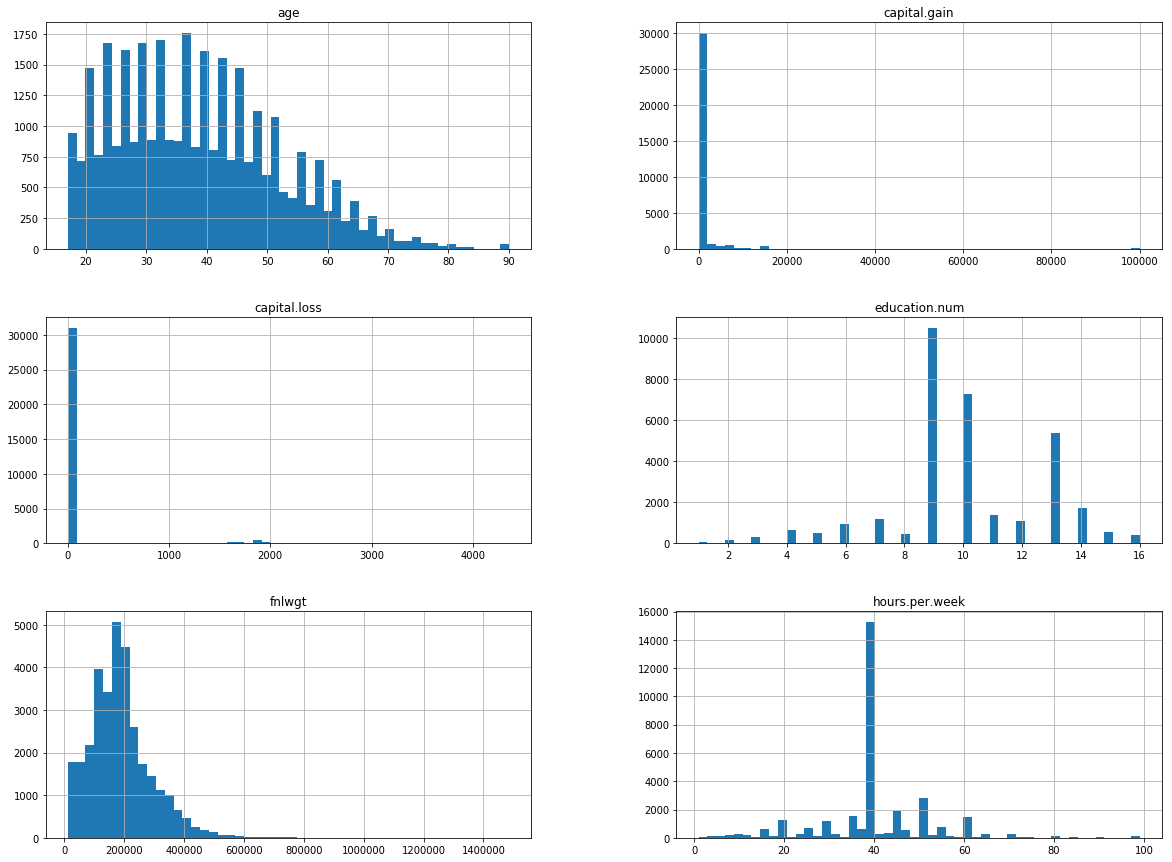

In [5]:
dataset.hist(bins=50, figsize=(20,15))

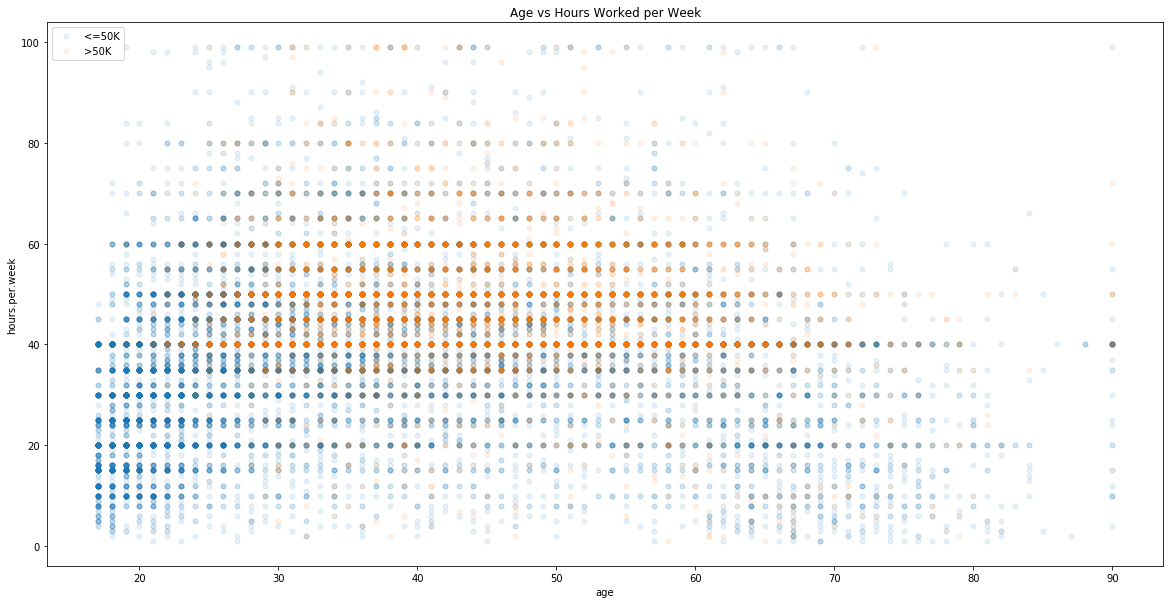

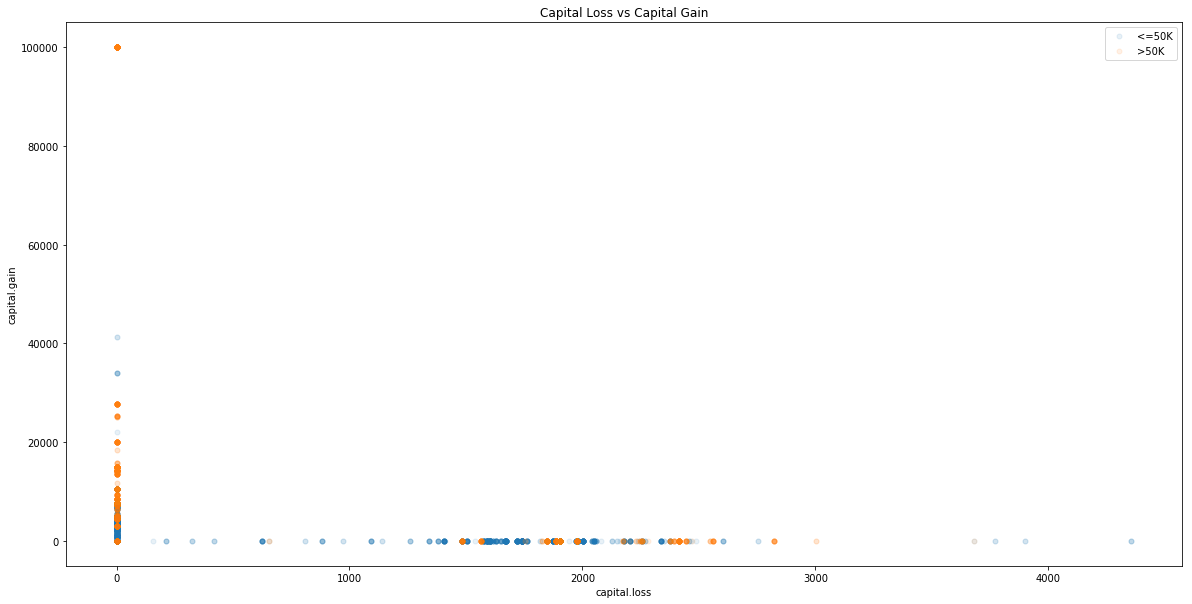

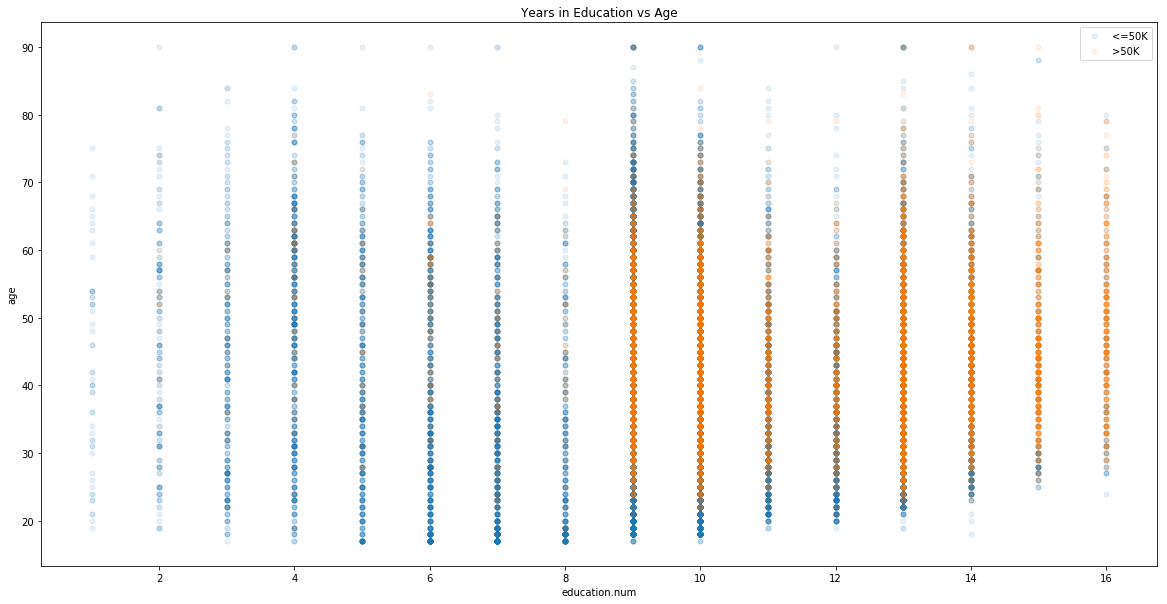

In [6]:
def createScatterSubPlot(x_feature, y_feature):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    for name, group in dataset.groupby('income'):
        ax.plot(group[x_feature], group[y_feature], marker='o', linestyle='', ms=5, label=name, alpha=0.1)
    ax.legend()
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)

createScatterSubPlot("age", "hours.per.week")
plt.title('Age vs Hours Worked per Week')
createScatterSubPlot("capital.loss", "capital.gain")
plt.title('Capital Loss vs Capital Gain')
createScatterSubPlot("education.num", "age")
plt.title('Years in Education vs Age')

plt.show()

Most people earning >50k have 9 years or more of education, are aged between around 25 and 60, work atleast 40 hours per week, and have experienced little capital loss.

#### Lets see how our dataset is divided

{'<=50K': 370800, '>50K': 117615}


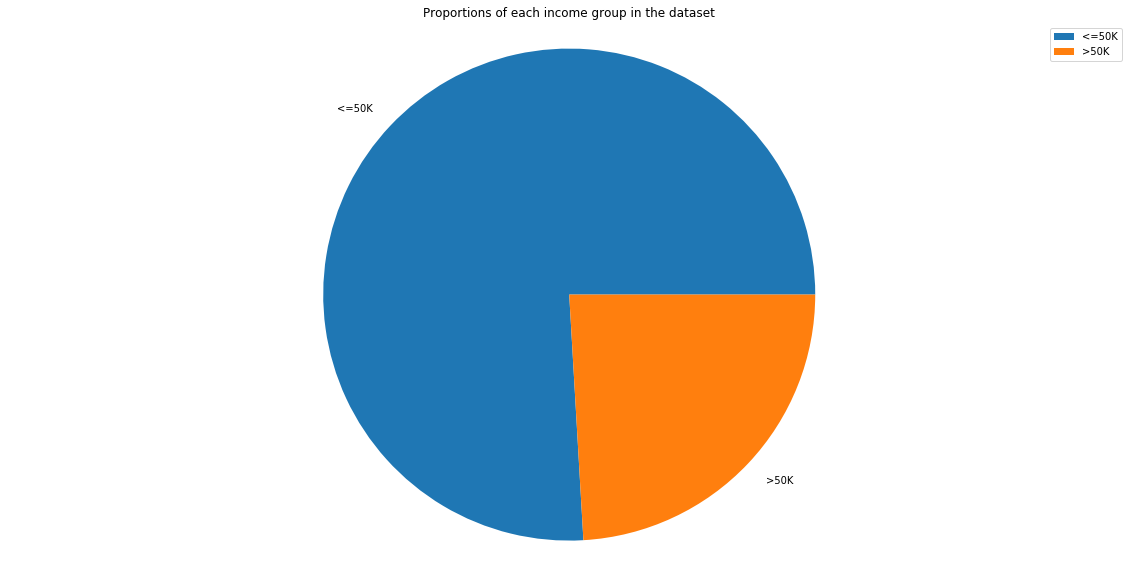

In [7]:
incomeCategories = dict()
for name, group in dataset.groupby('income'):
    incomeCategories[str(name)] = int(group.size)
 
print(incomeCategories)

fig, ax = plt.subplots(figsize=(20, 10))
ax.pie(list(incomeCategories.values()), labels=incomeCategories.keys())
ax.legend()
ax.axis('equal') 
plt.title('Proportions of each income group in the dataset')
plt.show()

{'<=50K': {'Female': 143880, 'Male': 226920}, '>50K': {'Female': 17685, 'Male': 99930}}


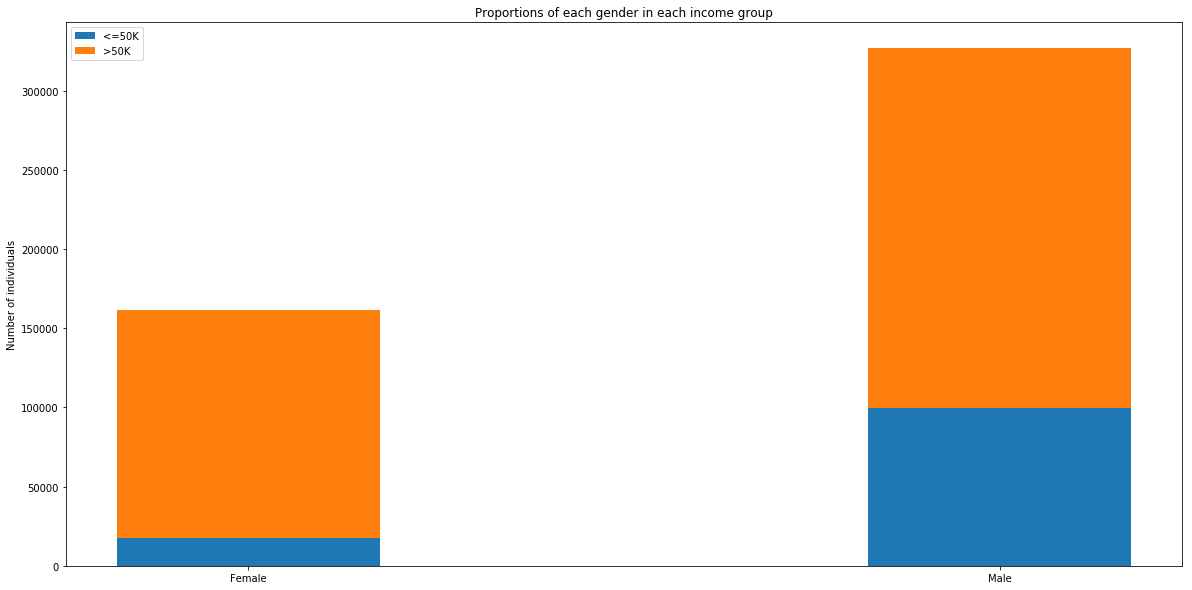

In [8]:
def countGroupOfGroups(topGroupName, secondGroupName):
    """Divide the dataset using two of its attributes, return a dictionary containing the counts of samples
    that fall into each group"""
    
    topCategories = dict()

    for name, group in dataset.groupby(topGroupName):
        subcategories = dict()
        subgroups = group.groupby(secondGroupName)

        for genderName, genderGroup in subgroups:
            subcategories[str(genderName)] = int(genderGroup.size)

        topCategories[str(name)] = subcategories
    
    return topCategories

# Plot how income is divided by gender
genderCategories = countGroupOfGroups("income", "sex")
print(genderCategories)

ind = np.arange(len(genderCategories["<=50K"])) 
barWidth = 0.35

plt.subplots(figsize=(20, 10))
p1 = plt.bar(ind, genderCategories[">50K"].values(), barWidth)
p2 = plt.bar(ind, genderCategories["<=50K"].values(), barWidth, bottom=genderCategories[">50K"].values())

plt.ylabel('Number of individuals')
plt.title('Proportions of each gender in each income group')
plt.xticks(ind, genderCategories["<=50K"].keys())
plt.legend((p1[0], p2[0]), genderCategories.keys())
plt.show()

More individuals in the dataset earn <=50k than >50k, and there are more men than women in the dataset. The proportion of women earning >50k is significantly smaller than the proportion of women earning <=50k. 

{'<=50K': {'Other': 3690, 'White': 310485, 'Black': 41055, 'Amer-Indian-Eskimo': 4125, 'Asian-Pac-Islander': 11445}, '>50K': {'Other': 375, 'White': 106755, 'Black': 5805, 'Amer-Indian-Eskimo': 540, 'Asian-Pac-Islander': 4140}}


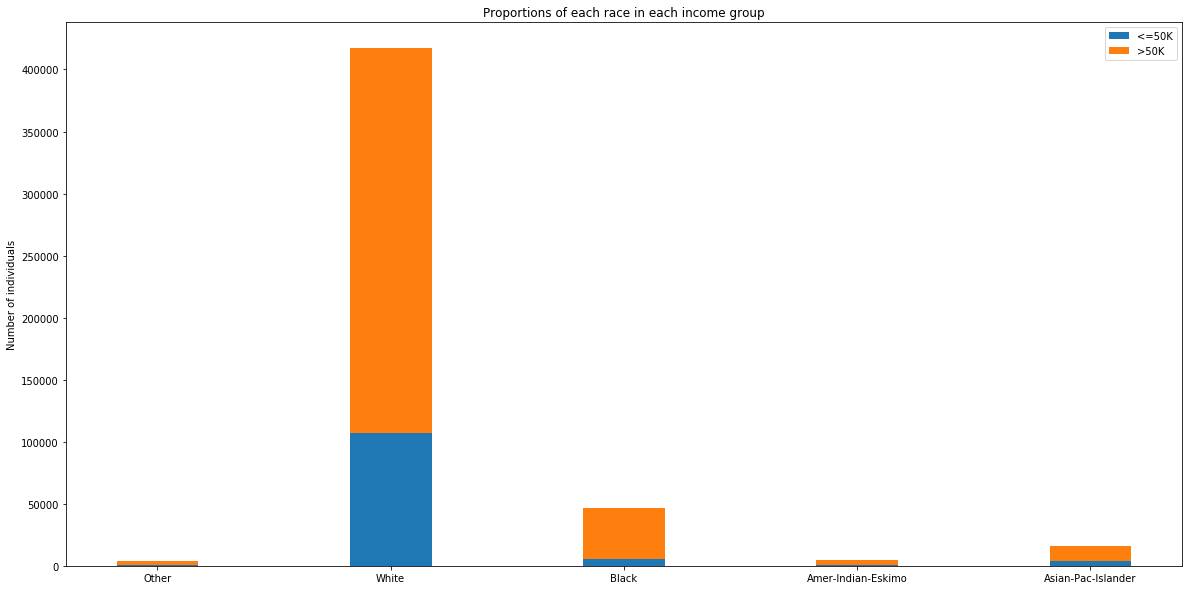

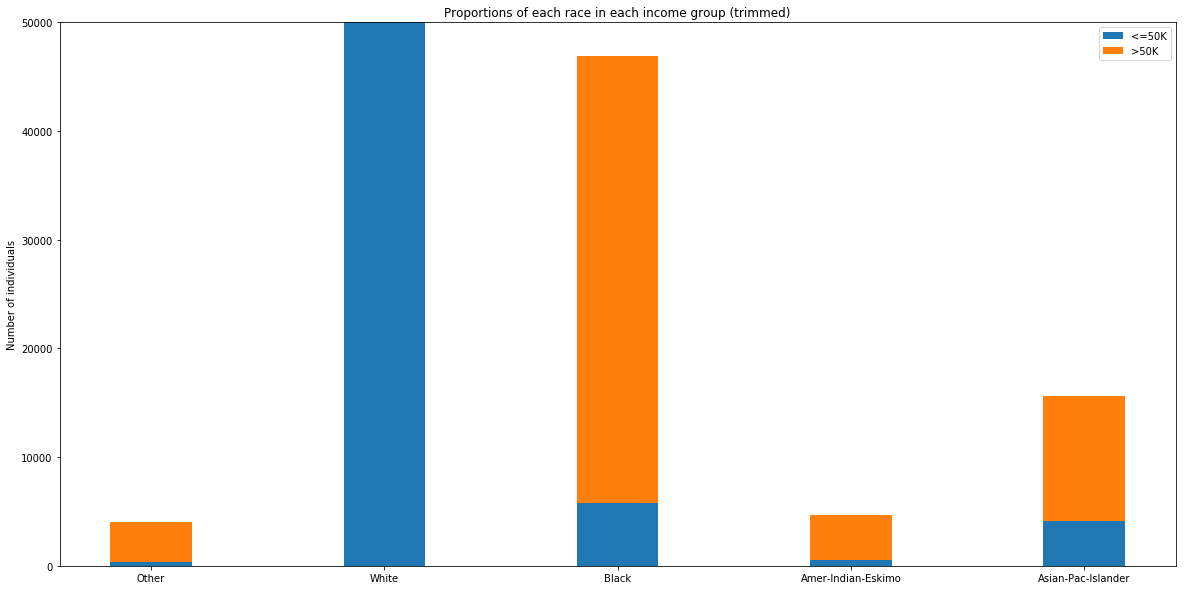

In [9]:
# Plot how income is divided by race
raceCategories = countGroupOfGroups("income", "race")
print(raceCategories)

ind = np.arange(len(raceCategories[">50K"])) 
barWidth = 0.35

plt.subplots(figsize=(20, 10))
p1 = plt.bar(ind, raceCategories[">50K"].values(), barWidth)
p2 = plt.bar(ind, raceCategories["<=50K"].values(), barWidth, bottom=raceCategories[">50K"].values())

plt.ylabel('Number of individuals')
plt.title('Proportions of each race in each income group')
plt.xticks(ind, raceCategories[">50K"].keys())
plt.legend((p1[0], p2[0]), raceCategories.keys())
plt.show()

# Plot the same thing again, but trim the y axis so that some areas of the graph are more visible
plt.subplots(figsize=(20, 10))
p1 = plt.bar(ind, raceCategories[">50K"].values(), barWidth)
p2 = plt.bar(ind, raceCategories["<=50K"].values(), barWidth, bottom=raceCategories[">50K"].values())

plt.ylabel('Number of individuals')
plt.title('Proportions of each race in each income group (trimmed)')
plt.xticks(ind, raceCategories[">50K"].keys())
plt.legend((p1[0], p2[0]), raceCategories.keys())
plt.ylim([0,50000])
plt.show()

Across all races more individuals earn <=50k than >50k, compared to other races a higher proportion of white individuals earn >50k than <=50k.

#### Prepare the test set

First we'll set aside the training set

In [10]:
X = dataset.drop("income", axis=1)
y = dataset["income"]

y_binarizer = LabelBinarizer()
y = y_binarizer.fit_transform(y).ravel()

print("X:\n", X.head(5))
print()
print("y:\n", y[0:5])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X:
    age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country  
0          4356              40  United-States  
1          4356              18  United-States  
2      

Now we're going to build the preparation pipeline. We'll use two pipelines in parallel, one for numerical features and another for categorical features.

In [11]:
NUMERICAL_FEATURES = list()
CATEGORICAL_FEATURES = list()

for featureNumber in range(X.values.shape[1]):
    if type(dataset.values[0, featureNumber]) is str:
        CATEGORICAL_FEATURES.append(dataset.columns.values[featureNumber])
    else:
        NUMERICAL_FEATURES.append(dataset.columns.values[featureNumber])

print("Numerical features:", NUMERICAL_FEATURES)
print()
print("Categorical features:", CATEGORICAL_FEATURES)

class FeatureSeparator(BaseEstimator, TransformerMixin): 
    """Class will drop features that do not match the provided names."""
    _featureNames = list()
    
    def __init__(self, featureNames):
        self._featureNames = featureNames

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self._featureNames].values

    
class MultiFeatureBinarizer(BaseEstimator, TransformerMixin):
    """Perform the binarization for each feature, returning a large matrix of all features."""
    _binarizers = list()
    
    def  __init__(self):
        return None
    
    def fit(self, X, y=None):
        """Builds and fits a list of LabelBinarizers, one for each feature"""
        NUM_FEATURES = X.shape[1]
        
        for featureNumber in range(NUM_FEATURES):
            binarizer = LabelBinarizer()
            binarizer.fit(X[:, featureNumber])
            self._binarizers.append(binarizer)
        
        return self
            
        
    def transform(self, X):
        """Performs the binarization and returns a matrix of all the new binary features."""
        retVal = np.empty((0, 0))
        
        for featureNumber in range(len(self._binarizers)):
            if (featureNumber == 0):
                retVal = self._binarizers[featureNumber].transform(X[:, featureNumber])
            else:
                retVal = np.concatenate((retVal, self._binarizers[featureNumber].transform(X[:, featureNumber])),
                                        axis=1)

        return retVal

    

numPipeline = Pipeline([ ('selector', FeatureSeparator(NUMERICAL_FEATURES)),
                         ('std_scaler', StandardScaler()) ])

catPipeline = Pipeline([ ('selector', FeatureSeparator(CATEGORICAL_FEATURES)),
                         ('multi_binarizer', MultiFeatureBinarizer()) ])

prepPipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', numPipeline),
    ('cat_pipeline', catPipeline)
])

X_train_prepared = prepPipeline.fit_transform(X_train)

print("First row of our prepared dataset:\n", X_train_prepared[0, :])
print("Samples, Features:", X_train_prepared.shape)

Numerical features: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

Categorical features: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


/Users/jack/anaconda3/envs/mlEnv_py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


First row of our prepared dataset:
 [ -7.71702419e-01  -4.66166606e-04  -4.18398764e-01  -1.46758329e-01
  -2.17272282e-01  -3.36547620e-02   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+0

Now we can train a random forest to assess feature importance

In [12]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_train_prepared, y_train)

featureImportances = dict()
for name, score in zip(dataset.columns.values, rnd_clf.feature_importances_):
    featureImportances[name] = score
    
importancesSortedKeys = sorted(featureImportances,
                               key=featureImportances.get,
                               reverse=True)

print("Feature importance:")
for key in importancesSortedKeys:
    print(key, featureImportances[key])

Feature importance:
workclass 0.159781738357
age 0.147032283091
education 0.0983698760044
marital.status 0.0821101883038
fnlwgt 0.0617369832203
education.num 0.0298179252496
capital.gain 0.010768723757
hours.per.week 0.00869033214837
capital.loss 0.00604576108545
race 0.0057093104907
relationship 0.00509452369086
native.country 0.00479365738265
occupation 0.00189135886025
income 7.20269834845e-05
sex 4.14898484384e-06


#### Training Models

Now that we've done some basic data preparation, we'll do a grid search of a few different models to see which are most promising

In [13]:
class Model:
    classifier = None
    gridSearch = None
    
    def __init__(self, classifier, paramGrid):
        self.classifier = classifier
    
        self.gridSearch = GridSearchCV(self.classifier,
                                      paramGrid,
                                      cv=5,
                                      scoring="neg_mean_squared_error")
        

        
        

# Create a dictionary of classifiers and grid search parameters
classifiers = dict()
classifiers["knn"] = Model(KNeighborsClassifier(),
                           [ {'n_jobs': [-1], 'n_neighbors': [2, 4, 6]} ])

classifiers["randomForest"] = Model(RandomForestClassifier(),
                                    [ {'n_jobs': [-1], 'n_estimators': [10, 100, 500]},
                                      {'n_jobs': [-1], 'n_estimators': [100], 'max_depth': [2, 20, 100]} ])

classifiers["sgd"] = Model(SGDClassifier(),
                           [ {"loss": ["hinge", "log"], 'penalty': ["l2", "l1"]} ])

classifiers["linearSVC"] = Model(LinearSVC(),
                                 [ {"C": [0.1, 1, 10]} ])

classifiers["rbfSVC"] = Model(SVC(),
                              [ {"C": [0.1, 1, 10], "kernel": ["rbf"]},
                                {"C": [0.1, 1, 10], "kernel": ["poly"], "degree": [2, 3]}])

In [14]:
classifiers["knn"].gridSearch.fit(X_train_prepared, y_train)